## Is it a bird?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

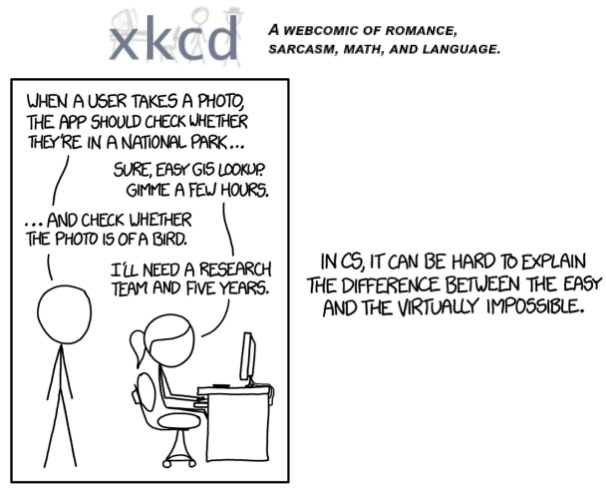

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [3]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
clean-fid 0.1.29 requires requests==2.25.1, but you have requests 2.28.1 which is incompatible.


In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [5]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://www.highreshdwallpapers.com/wp-content/uploads/2014/05/Colourful-Flying-Bird.jpg'

...and then download a URL and take a look at it:

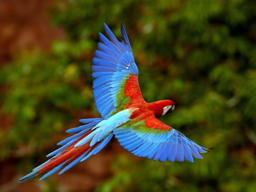

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

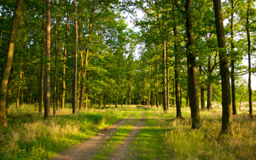

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

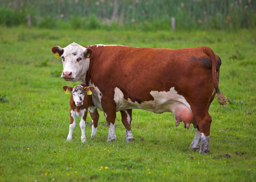

In [44]:
download_url(search_images('cow photos', max_images=1)[0], 'cow.jpg', show_progress=False)
Image.open('cow.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

## Sam's notes

- The code had changed to download 600 of each, with sun and shade.
- Forest vs bird isn't sufficient to check if something is a bird. e.g. a photo of a cow that I tested is predicted to be a bird.
- At first I changed it to search for landscape, forest, animal, and just plain "photo".
- Keep it simple, search for `bird photo` and `-bird photo`.
- Got confused with `penguin`, `butterfly`.
- The original `bird.jpg` and `forest.jpg` will likely appear in the training set or validation set, need to remove them to test it properly.
- Should remove duplicates, to avoid contaminating the validation set with images from training, and to avoid overfitting. I will use the tools `fdupes`, `findimagedupes`, and `qiv`.
- When removing duplicates, we can also remove knows birds that got into the `not_bird` set.
- `resize_images` may fail if we do it before `verify_images`, in which case we might not finish all the searches.
- `resize_images` doesn't work for files with unusual extensions. We should correct extensions first, or just remove those with unknown extensions.
- I tried hard to train it to handle more edge cases.
- I tested my "bird detector" on a large collection of animal photos and others photos. From a sample of 100 photos, it detected 39 as birds, however only 16 of those are actually photos of birds. So it had a nearly 60% false positive rate. The false negative rate was lower, close to zero.
- I would like to keep trying to improve the "bird detector", but for now, in conclusion, it seems to me that it is not a trivial task to train an ANN to reliably distinguish photos of birds from other images.

In [177]:
searches = [
    ('bird', 'photo bird', 100),
    ('bird', 'photo penguin', 50),
    ('bird', 'photo unusual bird', 50),
    ('bird', 'photo flightless bird', 50),
    ('bird', 'baby bird', 50),
    ('not_bird', 'photo -bird', 100),
    ('not_bird', 'photo butterfly', 50),
    ('not_bird', 'photo flying insect', 50),
    ('not_bird', 'photo flying bat', 50),
    ('not_bird', 'photo animal -bird', 50),
    ('not_bird', 'photo platypus', 50),
    ('not_bird_checkme', 'photo flying animal -bird', 50),
]
searches = [
    ('bird', 'duckling', 50),
]
path = Path('bird_or_not')
from time import sleep

for o, query, n in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(query, max_images=n))
    # sleep(10)  # Pause between searches to avoid over-loading server

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [185]:
!find bird_or_not -type f | xargs rename 's/\..*/.jpg/'

In [184]:
!find -name '.qiv-trash' | xargs mr

renamed './bird_or_not/not_bird/.qiv-trash' -> '/home/sam/rubbish/.qiv-trash_20221013_131455395334225+1100_fri_128578'


In [186]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

In [187]:
for o, query, n in searches:
    resize_images(path/o, max_size=400, dest=path/o)

In [83]:
shutil.move(path/'not_bird_checkme', 'not_bird_checkme')

'not_bird_checkme'

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

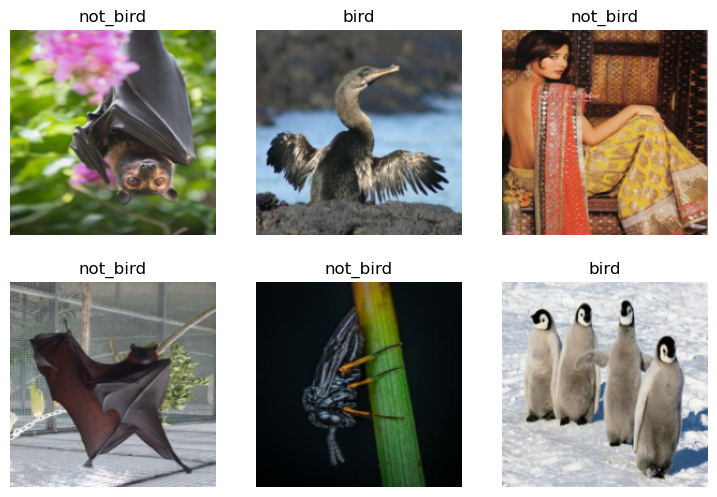

In [188]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [189]:
len(get_image_files(path)), len(dls.items), len(dls.valid.items)

(715, 572, 143)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [190]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.736536,0.314369,0.104895,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.139291,0.298413,0.097902,00:01
1,0.099214,0.118527,0.034965,00:01
2,0.069747,0.111985,0.055944,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [193]:
is_bird,_,probs = learn.predict(PILImage.create('check/baby_bird2.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: not_bird.
Probability it's a bird: 0.0465


In [199]:
check = []
for f in get_image_files(path/'../all-images')[:100]:
    is_bird,_,probs = learn.predict(PILImage.create(f))
    if is_bird != "bird":
        print(f"{f} : {is_bird} : {probs[0]:.4f}")
        check.append(f)

bird_or_not/../all-images/55778.jpg : not_bird : 0.0000


bird_or_not/../all-images/138365.jpg : not_bird : 0.0000


bird_or_not/../all-images/128047.jpg : not_bird : 0.0000


bird_or_not/../all-images/3899.jpg : not_bird : 0.0160


bird_or_not/../all-images/128266.jpg : not_bird : 0.0001


bird_or_not/../all-images/71514.jpg : not_bird : 0.0007


bird_or_not/../all-images/23210.jpg : not_bird : 0.2592


bird_or_not/../all-images/42233.jpg : not_bird : 0.0037


bird_or_not/../all-images/137568.jpg : not_bird : 0.0004


bird_or_not/../all-images/130001.jpg : not_bird : 0.0193


bird_or_not/../all-images/72036.jpg : not_bird : 0.0042


bird_or_not/../all-images/106790.jpg : not_bird : 0.0002


bird_or_not/../all-images/137151.jpg : not_bird : 0.1731


bird_or_not/../all-images/40925.jpg : not_bird : 0.0021


bird_or_not/../all-images/3410.jpg : not_bird : 0.1319


bird_or_not/../all-images/12371.jpg : not_bird : 0.0004


bird_or_not/../all-images/25200.jpg : not_bird : 0.0000


bird_or_not/../all-images/2025.jpg : not_bird : 0.0001


bird_or_not/../all-images/61381.jpg : not_bird : 0.0055


bird_or_not/../all-images/101879.jpg : not_bird : 0.0166


bird_or_not/../all-images/97488.jpg : not_bird : 0.0000


bird_or_not/../all-images/99806.jpg : not_bird : 0.0036


bird_or_not/../all-images/28320.jpg : not_bird : 0.2105


bird_or_not/../all-images/94219.jpg : not_bird : 0.0030


bird_or_not/../all-images/102354.jpg : not_bird : 0.0002


bird_or_not/../all-images/36906.jpg : not_bird : 0.0000


bird_or_not/../all-images/4481.jpg : not_bird : 0.0000


bird_or_not/../all-images/116457.jpg : not_bird : 0.0002


bird_or_not/../all-images/98029.jpg : not_bird : 0.0205


bird_or_not/../all-images/137076.jpg : not_bird : 0.0000


bird_or_not/../all-images/7839.jpg : not_bird : 0.0008


bird_or_not/../all-images/41564.jpg : not_bird : 0.1056


bird_or_not/../all-images/124110.jpg : not_bird : 0.0000


bird_or_not/../all-images/8037.jpg : not_bird : 0.0005


bird_or_not/../all-images/105801.jpg : not_bird : 0.0012


bird_or_not/../all-images/125425.jpg : not_bird : 0.0002


bird_or_not/../all-images/70761.jpg : not_bird : 0.0001


bird_or_not/../all-images/24112.jpg : not_bird : 0.2207


bird_or_not/../all-images/132931.jpg : not_bird : 0.0000


bird_or_not/../all-images/31619.jpg : not_bird : 0.0026


bird_or_not/../all-images/99214.jpg : not_bird : 0.0001


bird_or_not/../all-images/21490.jpg : not_bird : 0.0324


bird_or_not/../all-images/53097.jpg : not_bird : 0.0078


bird_or_not/../all-images/105354.jpg : not_bird : 0.0029


bird_or_not/../all-images/1580.jpg : not_bird : 0.0000


bird_or_not/../all-images/66993.jpg : not_bird : 0.0006


bird_or_not/../all-images/46953.jpg : not_bird : 0.0104


bird_or_not/../all-images/93374.jpg : not_bird : 0.0318


bird_or_not/../all-images/123946.jpg : not_bird : 0.0000


bird_or_not/../all-images/11161.jpg : not_bird : 0.0108


bird_or_not/../all-images/139633.jpg : not_bird : 0.0008


bird_or_not/../all-images/14714.jpg : not_bird : 0.0006


bird_or_not/../all-images/97265.jpg : not_bird : 0.0009


bird_or_not/../all-images/97351.jpg : not_bird : 0.0051


bird_or_not/../all-images/3137.jpg : not_bird : 0.0000


bird_or_not/../all-images/86790.jpg : not_bird : 0.0196


bird_or_not/../all-images/42149.jpg : not_bird : 0.0002


bird_or_not/../all-images/130262.jpg : not_bird : 0.0001


bird_or_not/../all-images/100469.jpg : not_bird : 0.0000


bird_or_not/../all-images/104016.jpg : not_bird : 0.0002


bird_or_not/../all-images/97171.jpg : not_bird : 0.0385


bird_or_not/../all-images/103432.jpg : not_bird : 0.0392


bird_or_not/../all-images/36249.jpg : not_bird : 0.0236


bird_or_not/../all-images/130513.jpg : not_bird : 0.0013


bird_or_not/../all-images/78636.jpg : not_bird : 0.0009


bird_or_not/../all-images/92633.jpg : not_bird : 0.0001


bird_or_not/../all-images/63715.jpg : not_bird : 0.0015


In [200]:
print("\n".join([Path(f).name for f in check]))

55778.jpg
138365.jpg
128047.jpg
3899.jpg
128266.jpg
71514.jpg
23210.jpg
42233.jpg
137568.jpg
130001.jpg
72036.jpg
106790.jpg
137151.jpg
40925.jpg
3410.jpg
12371.jpg
25200.jpg
2025.jpg
61381.jpg
101879.jpg
97488.jpg
99806.jpg
28320.jpg
94219.jpg
102354.jpg
36906.jpg
4481.jpg
116457.jpg
98029.jpg
137076.jpg
7839.jpg
41564.jpg
124110.jpg
8037.jpg
105801.jpg
125425.jpg
70761.jpg
24112.jpg
132931.jpg
31619.jpg
99214.jpg
21490.jpg
53097.jpg
105354.jpg
1580.jpg
66993.jpg
46953.jpg
93374.jpg
123946.jpg
11161.jpg
139633.jpg
14714.jpg
97265.jpg
97351.jpg
3137.jpg
86790.jpg
42149.jpg
130262.jpg
100469.jpg
104016.jpg
97171.jpg
103432.jpg
36249.jpg
130513.jpg
78636.jpg
92633.jpg
63715.jpg


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.